# Movies Recommender 🍿 - Building a Recommendation System
A project proposal by **Adi Benziony (ID 313364549)**

## Introduction and Motivation
The film industry is a giant business, and every year thousands of new movies are made. In 2019 alone 4,693 new movies were released ([source](https://www.the-numbers.com/movies/production-countries#tab=year)).  
With all those new movies released each year it can be confusing to choose which movies to see, and that's where a personalized recommendation system can come in handy.

The growth in digital data volume that's at the disposal of big companies allowed a new era of personalized recommendation systems to arise.  
Every company serving consumers content wants to find a way to keep the consumer engaged and entertained, one of the ways this can be achived is by making it easier for the user to find content he will like.  
Companies like Spotify, Netflix, Twitter, Facebook and even dating apps such as Tinder all have recommendation systems to keep users on the platform.

![Netflix recommendations](resources/recommendations-banner.png)

In this notebook we will use [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) posted on Kaggle to build **a recommendation system for movies based on a user's ratings**.

## Dataset
This project is inspired by the dataset [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) posted on Kaggle, featuring movies information like title, genres, release date and more along with users' movies ratings.  
The dataset is a combination of [_MovieLens_](https://movielens.org/) and [_TMDB_](https://www.themoviedb.org/).  
MovieLens is a research site run by _GroupLens Research_ at the University of Minnesota and contains users' movies ratings, and _TMDB_ is a website containing data on millions of movies.

Our dataset cotains:
* **45,000 movies** in various languages (but mostly English) with properties like budget, revenue, genres, language, release date, duration, and ratings.
* **26 million ratings by 260,000 users**

## Dataset Loading & Cleanup
We will start by loading `movies-dataset/movies_metadata.csv`.  
Note, the original CSV uploaded to Kaggle had some lines with unescaped newlines in their movie description fields, the CSV in the project's Git repository is a fixed version of the CSV from Kaggle.

Let's load the dataset and start inspecting it:

In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [263]:
movies_metadata = pd.read_csv('movies-dataset/movies_metadata.csv')
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  bool   
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  int64  
 3   genres                 45463 non-null  object 
 4   homepage               7779 non-null   object 
 5   id                     45463 non-null  int64  
 6   imdb_id                45446 non-null  object 
 7   original_language      45452 non-null  object 
 8   original_title         45463 non-null  object 
 9   overview               44509 non-null  object 
 10  popularity             45463 non-null  float64
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

We can see that the `release_date` field is not of type `datetime`, so let's change that:

In [264]:
movies_metadata = pd.read_csv('movies-dataset/movies_metadata.csv', parse_dates=['release_date'])

Let's also load the `credits.csv` and `keywords.csv` files

In [265]:
credits = pd.read_csv('movies-dataset/credits.csv')

In [266]:
keywords = pd.read_csv('movies-dataset/keywords.csv')
keywords_dups_count = keywords[keywords.duplicated()].shape[0]
keywords = keywords[~keywords.duplicated()]

print(f'Removed {keywords_dups_count} duplicated rows from `keywords`')

Removed 987 duplicated rows from `keywords`


# Data Exploration

Now for some exploration, let's look at some rows of our datasets:

In [267]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173


In [268]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [269]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


We can merge the 3 datasets into one, this will make it easier as we progress

In [270]:
movies = movies_metadata.merge(credits, on='id').merge(keywords, on='id')

We need to know who our recommendation system will cater to, this will depend on how much our dataset is skwed.  
So let's look at some basic statistics of language, budget, revenu, release dates, duration, votes count and genres.

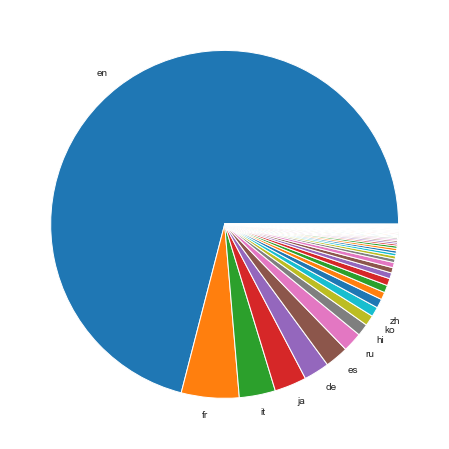

In [271]:
lng_counts = movies['original_language'].value_counts()

top_lng = lng_counts.index.tolist()[:10]
labels = top_lng + [""]*(lng_counts.index.size - 10)
plt.figure(figsize=(8, 8))
plt.pie(lng_counts, labels=labels)

plt.show()

English is the most dominent language in our dataset, while there's also French, Italian, Japanease, German, Spanish, Russian and more.

Let's look at statistics about the release dates and the duration:  

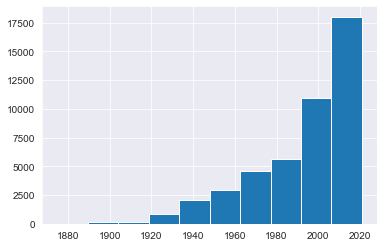

In [272]:
movies['release_date'].hist()
plt.show()

We can see that our dataset is comprised mainly from movies made in recent years, this doesn't necessarily mean that our data is skwed, maybe there really were more movies made in recent years than before.

In [273]:
movies[movies["runtime"] > 400][["title", "runtime", "overview", "keywords", "genres", "original_language", "imdb_id"]].shape

(50, 7)

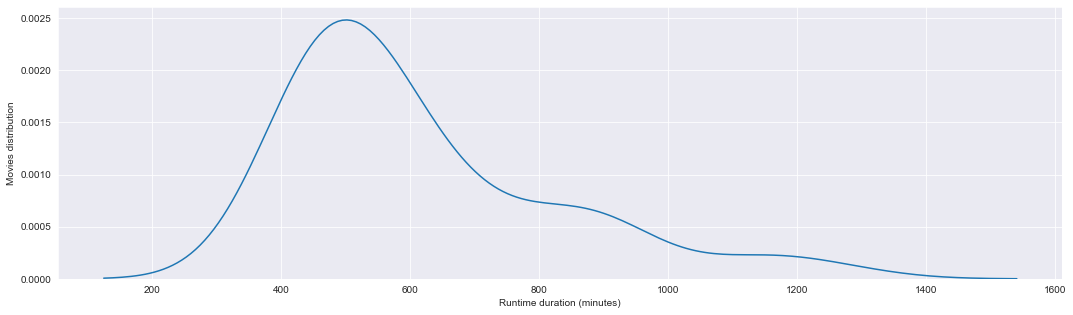

In [274]:
plt.figure(figsize=(18,5))
plt.xlabel("Runtime duration (minutes)")
plt.ylabel("Movies distribution")

# To make the plot more readable we'll remove movies with runtime of over 400 minutes (there's only 25 of them)
sns.kdeplot(data=movies[movies["runtime"] > 400], x="runtime")

plt.show()

The average duration is a little more than an hour and a half, and most movies are between an hour and 2 hours.

Next, let's take a look at the different genres.  
In order to do that we will need to make the genres data usable. Currently the genres of each movie is stored as follows:

In [275]:
movies[movies['title'] == 'Toy Story'][['title', 'genres']]

,title,genres
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."


We'll convert the `genres` field to a simple list of values, and we'll do the same for `cast`, `crew`, and `keywords`

In [276]:
movies["genres"] = movies["genres"].apply(lambda value: [x["name"] for x in eval(value)])
movies["cast"] = movies["cast"].apply(lambda value: [x["name"] for x in eval(value)])
movies["crew"] = movies["crew"].apply(lambda value: [x["name"] for x in eval(value)])
movies["keywords"] = movies["keywords"].apply(lambda value: [x["name"] for x in eval(value)])

To make it simpler to plot different aspects of movies' geners, we'll create a new `DataFrame` that will have a duplicate of each movie per its genre:

In [277]:
movies_genres = movies.explode('genres').rename(columns={'genres': 'genre'})

For example, for the movie "Toy Story" the `movies_genres` `DataFrame` will store the genres as follows:

In [278]:
movies_genres[movies_genres['title'] == 'Toy Story'][['title', 'genre']]

,title,genre
0,Toy Story,Animation
0,Toy Story,Comedy
0,Toy Story,Family


We have the following genres:

In [279]:
genres = movies_genres.groupby("genre").size()\
                    .reset_index().rename(columns={0: 'count'})\
                    .sort_values('count', ascending=False).reset_index(drop=True)

genres

,genre,count
0,Drama,20312
1,Comedy,13196
2,Thriller,7640
3,Romance,6746
4,Action,6607
5,Horror,4679
6,Crime,4314
7,Documentary,3937
8,Adventure,3508
9,Science Fiction,3061


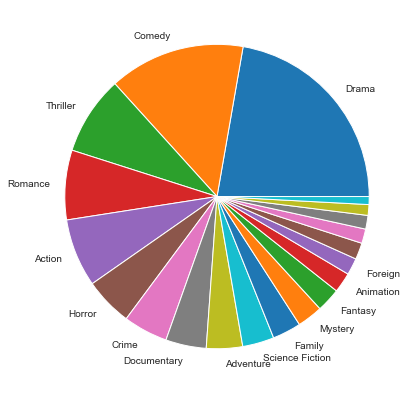

In [280]:
top_genres = genres["genre"].tolist()[:15]

genres_count = movies_genres['genre'].value_counts()
labels = top_genres + [""]*(genres_count.index.size - 15)
plt.figure(figsize=(7, 7))
a = plt.pie(genres_count, labels=labels)

It's clear that most movies produced are categorized as "Drama", "Comedy", "Thriller", "Romance", or "Action".

It will be interesting to see how different movie properties change based on genre. We'll keep it in mind going forward in this notebook.

Next, let's take a look at movies' votes

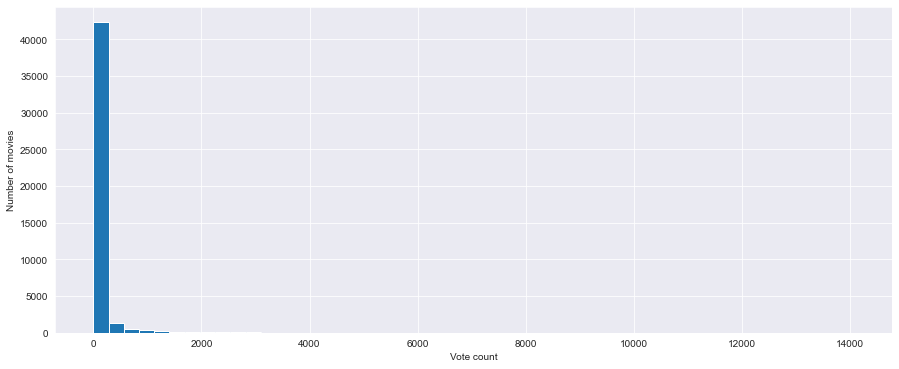

In [281]:
plt.figure(figsize=(15, 6))
movies['vote_count'].hist(bins=50)
plt.xlabel("Vote count")
plt.ylabel("Number of movies")
plt.show()

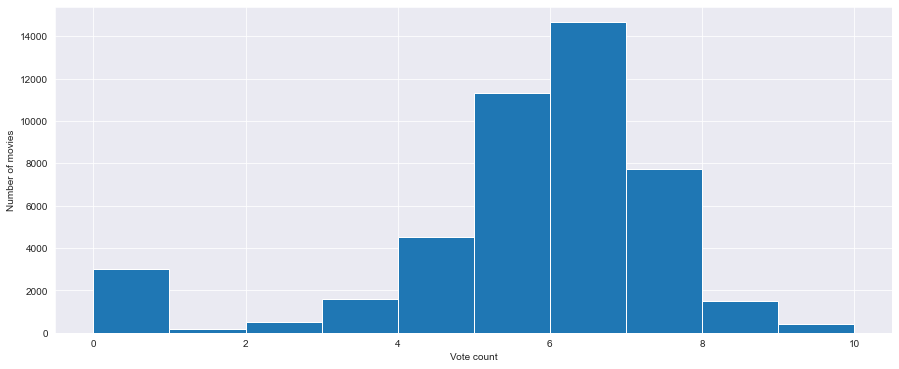

The average movie score is 5.6


In [282]:
plt.figure(figsize=(15, 6))
movies['vote_average'].hist()
plt.xlabel("Vote count")
plt.ylabel("Number of movies")
plt.show()

print(f'The average movie score is {movies["vote_average"].mean():.1f}')

We can deduce most movies have less than 500 ratings, and the average rating of a movie is 5.8

Next we will focus on the users ratings dataset from `movies-dataset/ratings.csv`

In [283]:
ratings = pd.read_csv('movies-dataset/ratings.csv').drop(columns=['timestamp'])
ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [284]:
ratings.shape

(26024289, 3)

In [285]:
ratings.value_counts('userId').describe()

count    270896.000000
mean         96.067454
std         205.719606
min           1.000000
25%          15.000000
50%          30.000000
75%          93.000000
max       18276.000000
dtype: float64

We have 26,024,289 ratings from 270,896 users with an average number of movies rated by a user to be 96.

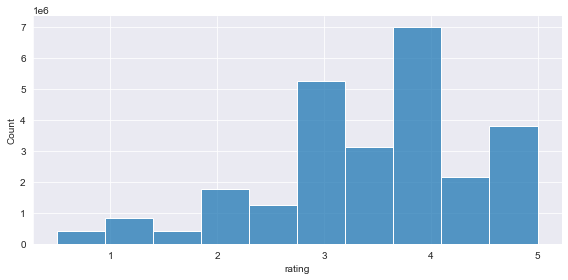

In [286]:
sns.set_style("darkgrid")
sns.displot(ratings, x="rating", bins=10, height=4, aspect=2)
plt.show()

Let's look at the most rated movies (by count) and the top rated movies (by score)

In [287]:
most_rated_movies = ratings.groupby('movieId').size()\
    .reset_index().rename(columns={0: 'count'})\
    .sort_values('count', ascending=False).reset_index(drop=True)
top_rated_movies = ratings.groupby('movieId').mean()\
    .drop(columns='userId').reset_index()\
    .sort_values('rating', ascending=False)\
    .reset_index(drop=True)
# m=movies.merge(links, left_on='id', right_on='tmdbId')

# movies = movies_metadata.merge(credits, on='id').merge(keywords, on='id')


Trying to merge the `movies` DataFrame with the `most_rated_movies` DataFrame shows a problem:

In [288]:
most_rated_movies.head(10).merge(movies, left_on='movieId', right_on='id')[["movieId", "title"]]

,movieId,title
0,318,The Million Dollar Hotel
1,296,Terminator 3: Rise of the Machines
2,593,Solaris
3,260,The 39 Steps
4,480,Monsoon Wedding
5,527,Once Were Warriors
6,110,Three Colors: Red


I don't recognize those movies, and seeing as those should be the movies with the most ratings this is unlikely.

Reading from the Kaggle project's description, I understand that the `id` column in `movies` DataFrame is probably the TMDB ID (the ID from the _The Movies Data Base_) where most info was scraped from and the `movieId` column in `ratings` is an ID from _MovieLens_ database, so let's fix that and make the `ratings` DataFrame have an `id` column like `movies`.

To do that we'll need another CSV that contains all the connections between the different IDs, the `links.csv` file

In [289]:
links = pd.read_csv('movies-dataset/links.csv')

In [290]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [291]:
ratings = ratings.merge(links, on='movieId')[["userId", "tmdbId", "rating"]]

Now, let's try to see the most rated movies' title

In [292]:
most_rated_movies = ratings.groupby('tmdbId').size()\
    .reset_index().rename(columns={0: 'count'})\
    .sort_values('count', ascending=False).reset_index(drop=True)
top_rated_movies = ratings.groupby('tmdbId').mean()\
    .drop(columns='userId').reset_index()\
    .sort_values('rating', ascending=False)\
    .reset_index(drop=True)

In [293]:
most_rated_movies.head(10).merge(movies, left_on='tmdbId', right_on='id')[["id", "title", "count"]]

,id,title,count
0,13,Forrest Gump,91921
1,278,The Shawshank Redemption,91082
2,680,Pulp Fiction,87901
3,274,The Silence of the Lambs,84078
4,603,The Matrix,77960
5,11,Star Wars,77045
6,329,Jurassic Park,74355
7,424,Schindler's List,67662
8,197,Braveheart,66512
9,862,Toy Story,66008


In [294]:
top_rated_movies.head(10).merge(movies, left_on='tmdbId', right_on='id')[["id", "title", "rating"]]

,id,title,rating
0,258113,Assepoester: Een Modern Sprookje,5.0
1,54583,Hollywood North,5.0
2,262831,Banana Paradise,5.0
3,262522,Poison,5.0
4,159550,The Last Brickmaker in America,5.0
5,69161,Heroes Shed No Tears,5.0
6,46121,The Capture of the Green River Killer,5.0
7,159763,A Nanny's Revenge,5.0
8,159898,The Boxing Cats (Prof. Welton's),5.0
9,159910,Hadj Cheriff,5.0


This list of movies makes more sense!

## Description Words

For each movie we the `keywords` and the `overview` columns that contain actual text that can help us understand the movie better than just very general labels like `genres`.

In [295]:
keywords_count_by_movie = movies["keywords"].apply(lambda keywords: len(keywords)).sort_values().to_frame()

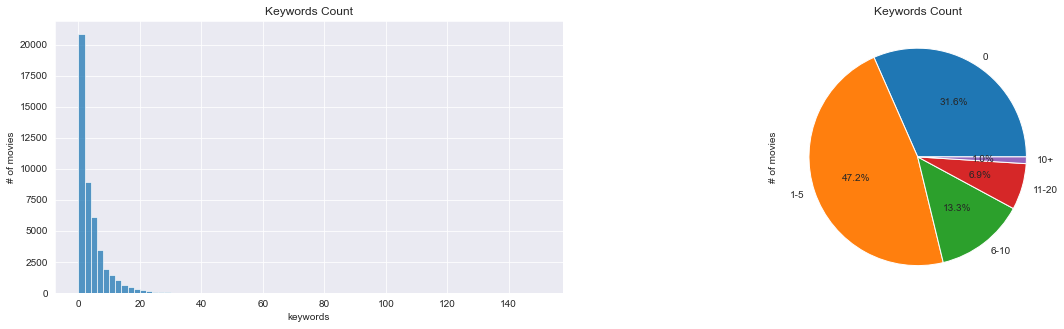

In [296]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
sns.histplot(data=keywords_count_by_movie, x="keywords", binwidth=2, ax=ax1)
ax1.title.set_text("Keywords Count")
ax1.set_ylabel("# of movies")

ax2 = plt.subplot(122)
keywords_bins_cut = pd.cut(keywords_count_by_movie["keywords"], bins=[-1, 0, 5, 10, 20, 200], labels=["0", "1-5", "6-10", "11-20", "10+"])
keywords_bins = keywords_bins_cut.to_frame().groupby('keywords').size()
keywords_bins.plot.pie(autopct="%1.1f%%", ax=ax2)
ax2.title.set_text("Keywords Count")
ax2.set_ylabel('# of movies')

plt.show()

So for most movies we don't have any keywords at all, and for those that do have almost all have less than 10 keywords describing them.

Most common keywords:

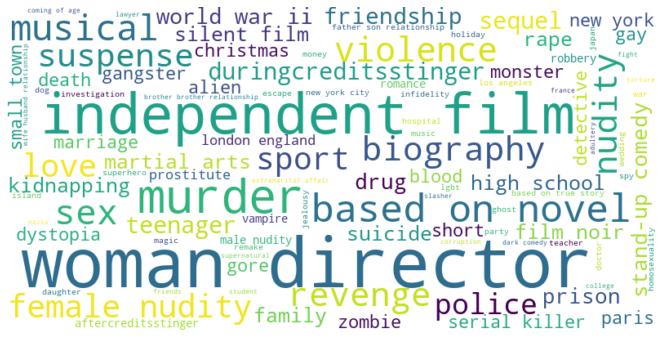

In [297]:
from wordcloud import WordCloud

keywords_freq = movies["keywords"].explode().dropna().value_counts()

wc = WordCloud(background_color="white", max_words=100, width=800, height=400)
wc.generate_from_frequencies(keywords_freq.to_dict())

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

plt.show()

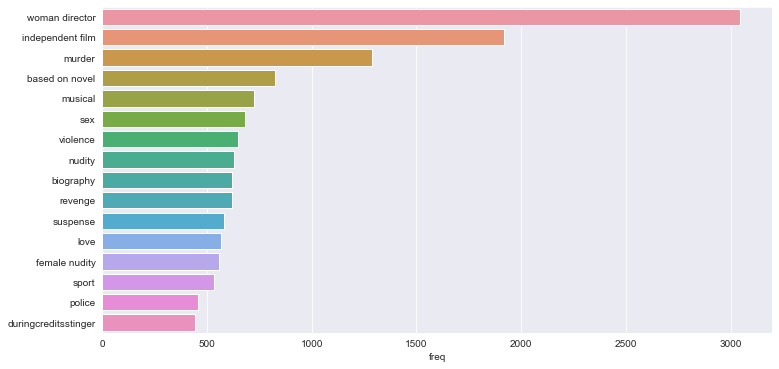

In [298]:
most_freq_keywords = keywords_freq.to_frame("freq").sort_values(by="freq", ascending=False).head(16)

plt.figure(figsize=(12, 6))
sns.barplot(data=most_freq_keywords, x="freq", y=most_freq_keywords.index, orient="h")
plt.show()

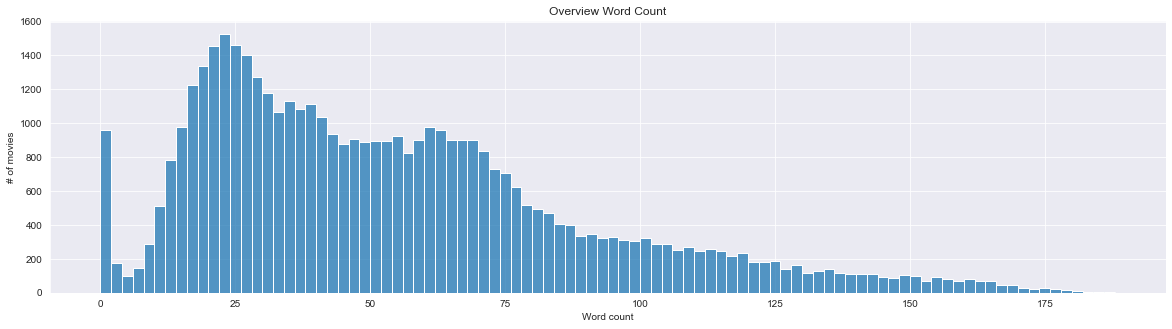

In [299]:
overview_word_count = movies["overview"].fillna("")\
    .apply(lambda overview: 0 if len(overview) == 0 else len(overview.split(" ")))\
    .to_frame()\
    .rename(columns={'overview': 'word_count'})
overview_word_count
plt.figure(figsize=(20, 5))

sns.histplot(data=overview_word_count, x="word_count", binwidth=2)
plt.title("Overview Word Count")
plt.ylabel("# of movies")
plt.xlabel("Word count")

plt.show()

## Finding Correlations

It can be interesting to try and find correlation between some parameters to the movie's vote average.  

Let's start by investigating the genre

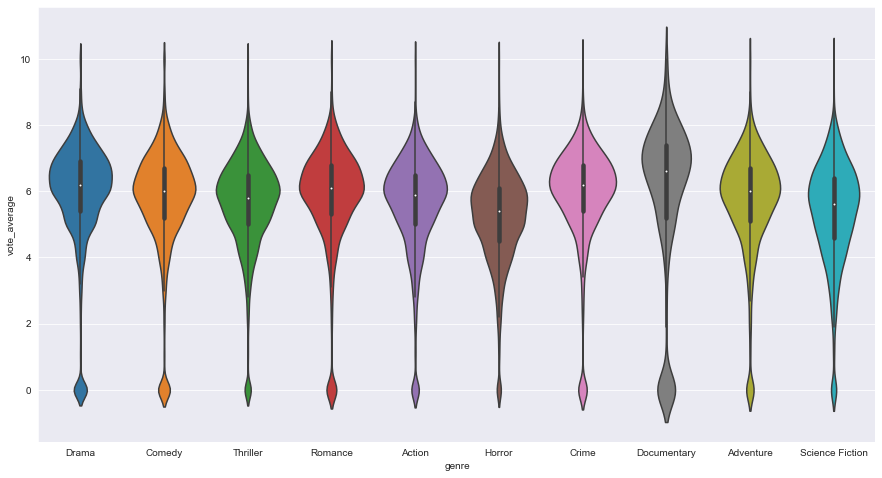

In [300]:
movies_in_top_genres = movies_genres[movies_genres['genre'].isin(top_genres[:10])]
plt.figure(figsize=(15,8))
sns.violinplot(x="genre", y="vote_average", data=movies_in_top_genres, order=top_genres[:10])
plt.show()

We can see that the average rating and its variance is consistent within the top 10 genres, with "Documentary" and "Science Fiction" being the only exception, they are more contreversial in comparsing to the rest of the genres.

# Building a Recommendation System

## Recommendation Systems Types

A recommendation system is a type of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item.  
There are 2 common types of recommendations systems _content based_ and _collaborative based_.

A __content based__ recommendations system uses the description of items and the user's past to recommend items the user might like. Those kind of systems rely on a well tagged dataset of items and the user's preferences

A __collaborative based__ recommendations system doesn't use data on the items at all, rather relying on finding similar interests between different users.  
This is based on the assumption that people who agreed in the past will agree in the future, and that they will like simimlar kinds of items as they liked in the past.The importance of analyzing users' preferences is key, with data collection being collected explicitly (likes, dislikes, ratings) and implicitly (viewing times).

Most recommendations systems feature a hybrid approch of those two methods.

I want to look at the problem from a number of different point of views, so I'll try to create multiple recommendation systems that each function in a different way, and in the end combine all of them.

## First Try - A Content Based Recommendation System

For a content based recommendation system, we need to find similarities between movies.
This is our plan:
1. Build the corpus - perform feature extraction
2. Find similarities - Create a function that accepts a movie title and grades all movies based on a similarity score
3. Create a function that accepts a user ID, and grades all movies based on a similarity score to all the movies that user watched
4. Modify 2 to take into account the rating the user gave for each movie in his movie history, this way we won't recommend movies similar to the movies the user didn't like

### Simple Tags

#### Stage 1 - Building The Corpus
Looking at our dataset, there are a couple of columns that can be very useful in finding similarities between movies:

In [337]:
# TODO: only top 3 in cast, plus director column and maybe more jobs, script writer
properties_columns = ["original_language", "genres", "cast", "crew", "keywords"]
movies[["title", *properties_columns]].head()

,title,original_language,genres,cast,crew,keywords
0,Toy Story,en,"[Animation, Comedy, Family]","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[John Lasseter, Joss Whedon, Andrew Stanton, J...","[jealousy, toy, boy, friendship, friends, riva..."
1,Jumanji,en,"[Adventure, Fantasy, Family]","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[Larry J. Franco, Jonathan Hensleigh, James Ho...","[board game, disappearance, based on children'..."
2,Grumpier Old Men,en,"[Romance, Comedy]","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[Howard Deutch, Mark Steven Johnson, Mark Stev...","[fishing, best friend, duringcreditsstinger, o..."
3,Waiting to Exhale,en,"[Comedy, Drama, Romance]","[Whitney Houston, Angela Bassett, Loretta Devi...","[Forest Whitaker, Ronald Bass, Ronald Bass, Ez...","[based on novel, interracial relationship, sin..."
4,Father of the Bride Part II,en,[Comedy],"[Steve Martin, Diane Keaton, Martin Short, Kim...","[Alan Silvestri, Elliot Davis, Nancy Meyers, N...","[baby, midlife crisis, confidence, aging, daug..."


In [302]:
movies = movies[movies["keywords"].apply(lambda x: len(x) >= 1)][movies["cast"].apply(lambda x: len(x) >= 1)]
movies.shape

/var/folders/tl/9n338bsj4217gjszrx8gmpg80000gn/T/ipykernel_71949/4237603047.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



(30218, 27)

There's two types of columns, strings and lists of strings.  
We can combine all the columns to create one big string that contains all words from all columns and then vectorize the final string.

For example, for the movie "Forrest Gump":

In [303]:
movies[movies['title'] == 'Forrest Gump']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
351,False,NaN,55000000,"[Comedy, Drama, Romance]",NaN,13,tt0109830,en,Forrest Gump,A man with a low IQ has accomplished great thi...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The world will never be the same, once you've ...",Forrest Gump,False,8.2,8147,"[Tom Hanks, Robin Wright, Gary Sinise, Mykelti...","[Robert Zemeckis, Wendy Finerman, Steve Tisch,...","[vietnam veteran, hippie, mentally disabled, r..."


We'll create the following string that represents it:

```
en Comedy Drama Romance TomHanks RobinWright GarySinise MykeltiWilliamson SallyField MichaelConnerHumphreys HannaHall HaleyJoelOsment SiobhanFallon AfemoOmilami PeterDobson SonnyShroyer GeorgeKelly SamAnderson MargoMoorer ChristopherJones KevinMangan BrettRice DanielC.Striepeke DavidBrisbin KirkWard MarlenaSmalls KittyK.Green MarkMatheisen AlHarrington JedGillin DonFischer MattWallace MikeJolly MichaelKemmerling JohnVoldstad DanielJ.Gillooly MichaelBurgess StevenGriffith MichaelMcFall MichaelMcFall ByronMinns StephenBridgewater JohnWilliamGalt IsabelRose RichardD'Alessandro MichaelJace GeoffreyBlake VanessaRoth DickCavett TiffanySalerno TiffanySalerno JoeAlaskey LazarusJackson LazarusJackson NoraDunfee HallieD'Amore MichaelMattison CharlesBoswell TimothyMcNeil BobPenny GregBrown TroyChristian BryanHanna ZachHanner AaronMichaelLacey JacquelineLovell BrendanShanahan WilliamShipman RobbSkyler MaryEllenTrainor RobertZemeckis WendyFinerman SteveTisch SteveStarkey DonBurgess AlanSilvestri ArthurSchmidt EricRoth WinstonGroom EllenLewis JoannaJohnston RickCarter LeslieMcDonald WilliamJamesTeegarden NancyHaigh HazelCatmull WilliamA.Kohout SusanSchuler-Page JayCannistraci RickSharp KacyMagedman WendyRichardson SteveArnold LindaBerger TonyFanning JeffPassanante RobinL.Miller StephenI.Erdberg DanielJ.Gillooly HugoHerrera KevinMangan DanOndrejko PaigeAugustine ClaireGaul RobertGreenfield ChrisL.Spellman JamesC.Feng ErinKemp ElizabethLapp LaurenE.Polizzi SueFox TomBarwick DennieThorpe ClaireSanfilippo DiannaStirpe EwaSztompke E.LarryOatfield RobertShoup DennisS.Sands RandyThom GloriaS.Borders GeorgeMurphy StephenRosenbaum DougChiang DebbieDenise DebbieDenise MichaelMcGovern KenRalston BudDavis DavidM.Dunlap ChrisSquires PhillipV.Caruso DanBronson PamelaWise PatriciaBercsi RudolphGarcia StephenP.Shubin Carin-AnneStrohmaier KennethKarman JoelMarrow LeslieCook PeggyPridemore AmyNess MaryMorgan JessicaDrake JaneE.Russell CharlesNewirth LeighFrench JoeMontenegro BobbyMancuso WilliamB.Kaplan GregMaloney JudithA.Cory AllenHall JeremiahO'Driscoll StevenJ.Boyd RickPorras BruceMoriarty LindseyBuckingham RobertJ.Groden SusanMalerstein CraigLyman CynthiaQuan BarrySpencer BrettHaas SamuelRayJablonski StefanDechant ChrisJohnson JohnGazdik IsmaelAraujoJr. JessicaFasman HallieD'Amore AlleeneC.Keith WilliamAlford ScottMobley AmyPanzer JimDePue JoelSill TylerC.Daum TimothyGreenwood KeithCampbell RandyCantor WayneRoberts CharlesNewirth JoeyBox BobKaiser SamTaybi DanCornwall AndyRyan DavidR.Christensen E.ScottMayhugh DavidBrymer MichaelTadross DebraJames EarlSampson DavidFranklinBergad WilliamRoss JonathanGaynor AnneCalanchini ErikTIemens ChristianeSteffen vietnamveteran hippie mentallydisabled running basedonnovel vietnam vietnamwar friendship love familyrelationships bully mothersonrelationship military hugging shrimping woundedsoldier flashback parkbench amputee 
```

Columns cotaining lists of strings might have strings with multiple words, for example, the `actors` column might contain `["Tom Hanks", "George Kelly", "Tom Holloway"]`, so the final string representing the movie will be `".. Tom Hanks George Kelly Tom Holloway .."`, and so we won't be able to differentiate between Tom Hanks and Tom Holloway, to fix this we'll remove spaces between words in the same string

In [304]:
corpus = []

for _, m in movies.fillna({"original_language": ""}).iterrows():
    movie_prop = ""
    for property_column in properties_columns:
        value = m[property_column]
        if isinstance(value, list):
            # We'll remove all inner spaces to differentiate between i.e. "Tom Holloway" and "Tom Hanks"
            no_spaces_value = [item.replace(' ', '') for item in value]
            movie_prop += " ".join(no_spaces_value)
        else:
            movie_prop += value
        movie_prop += " "
    corpus.append(movie_prop)

At first, I opted to use TF-IDF for feature extraction, but on a second thought - the strings we're dealing with don't have the characteristics of actual documents, specifically, we don't want to reduce the importance of words that occur frequently in documents.  
So word counting will be used for feature extraction (without taking into account document frequency), specifically `HashingVectorizer` for its more efficient memory consumption.

In [305]:
from sklearn.feature_extraction.text import HashingVectorizer

transformer = HashingVectorizer(stop_words="english")
hashing_matrix = transformer.fit_transform(corpus)

#### Stage 2 - Finding Similarities

Now we will build a function that takes a movie and returns the top most similar movies

In [306]:
from sklearn.metrics.pairwise import linear_kernel


def find_similar_movies(df, title, top_n=5):
    # We have to reindex the movies DataFrame because later we use indexing into the matrix
    reindexed_movies = df.reset_index(drop=True)

    ind = reindexed_movies[reindexed_movies["title"] == title].index.item()

    # Instead of building a matrix of similarities between all movies, we just compare
    # the movie we're interested in with all the movies - this way we don't need too much memory
    sim = linear_kernel(hashing_matrix[ind:ind + 1, :].todense(), hashing_matrix)

    m_sim = sim[0]

    top_sims = m_sim.argsort()[-1 - top_n:-1]
    top_sims = np.flip(top_sims)

    similar_movies = reindexed_movies.iloc[top_sims]

    return similar_movies

Now let's see some results!

In [307]:
find_similar_movies(movies, 'Pulp Fiction')[["id", "title", "genres", "keywords", "cast", "crew"]]

/Users/adi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



,id,title,genres,keywords,cast,crew
914,500,Reservoir Dogs,"[Crime, Thriller]","[traitor, jewelry, psychopath, thief, heist, b...","[Harvey Keitel, Tim Roth, Michael Madsen, Chri...","[Quentin Tarantino, Quentin Tarantino, Lawrenc..."
16,5,Four Rooms,"[Crime, Comedy]","[hotel, new year's eve, witch, bet, hotel room...","[Tim Roth, Antonio Banderas, Jennifer Beals, M...","[Combustible Edison, Gary Frutkoff, Lance Brow..."
1437,184,Jackie Brown,"[Comedy, Crime, Romance]","[airport, underworld, arms deal, weapon, polic...","[Pam Grier, Samuel L. Jackson, Robert Forster,...","[Quentin Tarantino, Quentin Tarantino, Lawrenc..."
6272,393,Kill Bill: Vol. 2,"[Action, Crime, Thriller]","[brother brother relationship, swordplay, kata...","[Uma Thurman, David Carradine, Daryl Hannah, M...","[Robert Rodriguez, Quentin Tarantino, Quentin ..."
21068,273248,The Hateful Eight,"[Crime, Drama, Mystery, Western]","[bounty hunter, wyoming, mountain, narration, ...","[Samuel L. Jackson, Kurt Russell, Jennifer Jas...","[Quentin Tarantino, Quentin Tarantino, Robert ..."


In [308]:
find_similar_movies(movies, 'Avengers: Age of Ultron')[["id", "title", "genres", "keywords", "cast", "crew"]]

/Users/adi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



,id,title,genres,keywords,cast,crew
17164,76338,Thor: The Dark World,"[Action, Adventure, Fantasy]","[marvel comic, superhero, based on comic, host...","[Chris Hemsworth, Natalie Portman, Tom Hiddles...","[Priscilla John, Wendy Partridge, Sarah Finn, ..."
14522,24428,The Avengers,"[Science Fiction, Action, Adventure]","[new york, shield, marvel comic, superhero, ba...","[Robert Downey Jr., Chris Evans, Mark Ruffalo,...","[Alan Silvestri, Christopher Boyes, Christophe..."
17830,100402,Captain America: The Winter Soldier,"[Action, Adventure, Science Fiction]","[washington d.c., future, shield, marvel comic...","[Chris Evans, Samuel L. Jackson, Scarlett Joha...","[Sarah Finn, Beat Frutiger, Christopher Markus..."
18295,118340,Guardians of the Galaxy,"[Action, Science Fiction, Adventure]","[marvel comic, spaceship, space, outer space, ...","[Chris Pratt, Zoe Saldana, Dave Bautista, Vin ...","[Craig Wood, Christopher Boyes, Christopher Bo..."
13935,10195,Thor,"[Adventure, Fantasy, Action]","[new mexico, banishment, shield, marvel comic,...","[Chris Hemsworth, Natalie Portman, Tom Hiddles...","[Paul Rubell, Sarah Finn, Bo Welch, Stan Lee, ..."


In [309]:
find_similar_movies(movies, 'Shutter Island')[["id", "title", "genres", "keywords", "cast", "crew"]]

/Users/adi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



,id,title,genres,keywords,cast,crew
14702,44826,Hugo,"[Adventure, Drama, Family]","[library, clock, film director, key, toy, boy,...","[Ben Kingsley, Sacha Baron Cohen, Asa Butterfi...","[Johnny Depp, Robert Richardson, Howard Shore,..."
1438,9746,Kundun,[Drama],"[buddhism, china, mountain, buddhist monk, tib...","[Tenzin Thuthob Tsarong, Tencho Gyalpo, Tsewan...","[Martin Scorsese, Melissa Mathison, Barbara De..."
23667,5804,The Key to Reserva (La clave Reserva),"[Crime, Thriller]","[bird, key, orchestra, murder, alfred hitchcoc...","[Kelli O'Hara, Simon Baker, Martin Scorsese, M...","[Bernard Herrmann, Ellen Kuras, Martin Scorses..."
8174,2567,The Aviator,[Drama],"[ladykiller, pilot, biography, womanizer, avia...","[Leonardo DiCaprio, Cate Blanchett, Kate Becki...","[Crys Forsyth-Smith, Robert Richardson, Howard..."
5059,3131,Gangs of New York,"[Drama, History, Crime]","[fire, irish-american, immigrant, gang war, pi...","[Leonardo DiCaprio, Daniel Day-Lewis, Cameron ...","[Gerry Robert Byrne, Howard Shore, Martin Scor..."


### Doc2Vec

In [310]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [311]:
import gensim

def read_corpus():
    for index, row in movies[~movies["overview"].isna()].iterrows():
        tokens = gensim.utils.simple_preprocess(row['overview'])
        yield gensim.models.doc2vec.TaggedDocument(tokens, [str(index)])

In [312]:
train_corpus = list(read_corpus())

In [313]:
import os

if not os.path.exists(".cache/overviews.model"):
    model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=4, epochs=30)
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    os.makedirs(".cache", exist_ok=True)
    model.save(".cache/overviews.model")
else:
    model = gensim.models.doc2vec.Doc2Vec.load(".cache/overviews.model")

2022-07-14 11:46:47,355 : INFO : loading Doc2Vec object from .cache/overviews.model
2022-07-14 11:46:47,453 : INFO : loading dv recursively from .cache/overviews.model.dv.* with mmap=None
2022-07-14 11:46:47,455 : INFO : loading wv recursively from .cache/overviews.model.wv.* with mmap=None
2022-07-14 11:46:47,458 : INFO : setting ignored attribute cum_table to None
2022-07-14 11:46:50,376 : INFO : Doc2Vec lifecycle event {'fname': '.cache/overviews.model', 'datetime': '2022-07-14T11:46:50.376614', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


In [314]:
def find_most_similar(movie_title: str):
    overview = movies[movies['title'] == movie_title].iloc[0]['overview']
    overview_toks = gensim.utils.simple_preprocess(overview)

    overview_vec = model.infer_vector(overview_toks)
    similarities = model.dv.most_similar([overview_vec], topn=len(model.dv))
    for tag, similarity in similarities:
        yield movies.loc[int(tag)]['title'], similarity

# find_most_similar("Toy Story")

In [315]:
def compare(movie1, movie2):
    overview = movies[movies['title'] == movie1].iloc[0]['overview']
    overview2 = movies[movies['title'] == movie2].iloc[0]['overview']

    overview_toks = gensim.utils.simple_preprocess(overview)
    overview2_toks = gensim.utils.simple_preprocess(overview2)

    overview_vec = model.infer_vector(overview_toks)
    overview2_vec = model.infer_vector(overview2_toks)

    # model.dv.cosine_similarities(overview_toks, overview2_toks)
    similarity_score = model.dv.cosine_similarities(overview_vec, [overview2_vec]).item()

    print(f'{movie1} <> {movie2} - {similarity_score:.4f}')

compare('Toy Story', 'Toy Story 2')
compare('Toy Story', 'Toy Story 2')
compare('Toy Story', 'Finding Nemo')
compare('Shutter Island', 'Finding Nemo')
compare('Toy Story', 'Shutter Island')
compare('Fight Club', 'Shutter Island')

Toy Story <> Toy Story 2 - 0.4700
Toy Story <> Toy Story 2 - 0.5024
Toy Story <> Finding Nemo - 0.1924
Shutter Island <> Finding Nemo - 0.3368
Toy Story <> Shutter Island - 0.1766
Fight Club <> Shutter Island - 0.0895


In [316]:
for title in ['Toy Story', 'Toy Story 2', 'Shutter Island', 'Finding Nemo', 'Pulp Fiction']:
    print(f'# {title}')
    print(movies[movies["title"] == title].iloc[0]["overview"])
    print()

# Toy Story
Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.

# Toy Story 2
Andy heads off to Cowboy Camp, leaving his toys to their own devices. Things shift into high gear when an obsessive toy collector named Al McWhiggen, owner of Al's Toy Barn kidnaps Woody. Andy's toys mount a daring rescue mission, Buzz Lightyear meets his match and Woody has to decide where he and his heart truly belong.

# Shutter Island
World War II soldier-turned-U.S. Marshal Teddy Daniels investigates the disappearance of a patient from a hospital for the criminally insane, but his efforts are compromised by his troubling visions and also by a mysterious doctor.

# Finding Nemo
Nemo, an adventurous young clownfish, is unexpectedly taken from his Great Barri

In [317]:
def find_most_similar_g_tf(movie_title: str):
    sim_df = movies.copy()

    ind = sim_df[sim_df["title"] == movie_title].index.item()
    sim_matrix = linear_kernel(hashing_matrix[ind:ind + 1, :].todense(), hashing_matrix)

    m_sim = sim_matrix[0]

    sim_df["tfidf_similarity"] = m_sim

    overview = movies[movies['title'] == movie_title].iloc[0]['overview']
    overview_toks = gensim.utils.simple_preprocess(overview)
    overview_vec = model.infer_vector(overview_toks)
    
    tag_and_similarities = model.dv.most_similar([overview_vec], topn=len(model.dv))
    d2v_similarities = {int(tag): similarity for tag, similarity in tag_and_similarities}
    sim_df["d2v_similarity"] = pd.Series(data=d2v_similarities)
    sim_df["d2v_similarity"] = sim_df["d2v_similarity"].fillna(0)

    sim_df["sim_average"] = sim_df.apply(lambda row: (row["d2v_similarity"] + row["tfidf_similarity"]) / 2 ,axis=1)
    
    return sim_df.sort_values(by=['sim_average'], ascending=False).head(10)

find_most_similar_g_tf("Toy Story")[["title", "overview", "sim_average", "tfidf_similarity", "d2v_similarity"]]

/Users/adi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



,title,overview,sim_average,tfidf_similarity,d2v_similarity
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",0.959129,1.000000,0.918257
3008,Toy Story 2,"Andy heads off to Cowboy Camp, leaving his toy...",0.288265,0.415067,0.161463
2250,A Bug's Life,"On behalf of ""oppressed bugs everywhere,"" an i...",0.284990,0.245523,0.324457
12748,WALL·E,WALL·E is the last robot left on an Earth that...,0.273770,0.218236,0.329304
41428,The Secret Garden,When a spoiled English girl living in 19th cen...,0.272433,0.027778,0.517088
15413,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven...",0.251022,0.268752,0.233293
3024,The Bonfire of the Vanities,"After his mistress runs over a young teen, a W...",0.250855,0.035533,0.466176
37,It Takes Two,Identical 9-year-olds from very different back...,0.250328,0.050252,0.450404
27465,Who Was That Lady?,In order to get back into the good graces with...,0.248460,0.030241,0.466679
9164,Thursday,Casey has given up drug dealing for a suburban...,0.237927,0.012270,0.463583


### TF-IDF

In [318]:
corpus = movies['overview'].fillna("").tolist()

In [319]:
from sklearn.feature_extraction.text import TfidfVectorizer

transformer = TfidfVectorizer(stop_words="english")
tfidf_matrix = transformer.fit_transform(corpus)

In [320]:
from sklearn.metrics.pairwise import linear_kernel


def find_similar_movies_tfidf(df, title, top_n=5):
    # We have to reindex the movies DataFrame because later we use indexing into the matrix
    reindexed_movies = df.reset_index(drop=True)

    ind = reindexed_movies[reindexed_movies["title"] == title].index.item()

    # Instead of building a matrix of similarities between all movies, we just compare
    # the movie we're interested in with all the movies - this way we don't need too much memory
    sim = linear_kernel(tfidf_matrix[ind:ind + 1, :].todense(), tfidf_matrix)

    m_sim = sim[0]

    top_sims = m_sim.argsort()[-1 - top_n:-1]
    top_sims = np.flip(top_sims)

    similar_movies = reindexed_movies.iloc[top_sims]

    return similar_movies

find_similar_movies_tfidf(movies, 'Toy Story', 10)[["title", "overview", "genres"]]

/Users/adi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



,title,overview,genres
12781,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven...","[Animation, Family, Comedy]"
2631,Toy Story 2,"Andy heads off to Cowboy Camp, leaving his toy...","[Animation, Comedy, Family]"
18792,Small Fry,A fast food restaurant mini variant of Buzz fo...,"[Animation, Family]"
8794,The 40 Year Old Virgin,Andy Stitzer has a pleasant life with a nice a...,"[Comedy, Romance]"
18358,Andy Hardy's Blonde Trouble,Andy is going to Wainwright College as did his...,"[Comedy, Family, Romance]"
28870,Andy Peters: Exclamation Mark Question Point,Exclamation Mark Question Point is the debut s...,[Comedy]
927,Rebel Without a Cause,"After moving to a new town, troublemaking teen...",[Drama]
20537,Life Begins for Andy Hardy,"With his high school graduation behind him, An...","[Comedy, Romance]"
27461,Wabash Avenue,Andy Clark discovers he was cheated out of a h...,[Music]
25372,Welcome to Happiness,There's a magical door in Woody's closet that ...,"[Fantasy, Comedy, Drama]"


### Word2Vec

In [321]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

2022-07-14 11:46:55,405 : INFO : loading projection weights from /Users/adi/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
2022-07-14 11:54:05,185 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/adi/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-07-14T11:54:05.185807', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'load_word2vec_format'}


In [322]:
import gensim
from gensim.models.keyedvectors import KeyedVectors
from nltk.tokenize import word_tokenize

wv: KeyedVectors

not_found = set()
def generate_w2v(overview: str):
    tokens = word_tokenize(overview)

    a = np.empty((0, 300), np.float32)
    for token in tokens:
        try:
            a = np.append(a, np.array([wv[token]]), axis=0)
        except KeyError:
            not_found.add(token)

    return np.mean(a, axis=0)

movies["w2v"] = movies["overview"].apply(lambda overview: generate_w2v(overview) if isinstance(overview, str) else np.nan)
print(f'Failed to find {len(not_found)} words')

Failed to find 17335 words


In [323]:
from sklearn.metrics.pairwise import cosine_similarity

def get_w2v(title: str):
    return movies[movies["title"] == title].iloc[0]["w2v"]


def w2v_similarity(title1, title2):
    return cosine_similarity([get_w2v(title1)], [get_w2v(title2)]).item()

for m1, m2 in [
    ("Toy Story", "Toy Story 2"),
    ("Toy Story", "Finding Dory"),
    ("Toy Story", "Finding Nemo"),
    ("Toy Story", "Inside"),
    ("Toy Story", "Shutter Island"),
    ("Fight Club", "Shutter Island"),
    ("Fight Club", "The Truman Show"),
    ("Fight Club", "Requiem for a Dream"),
    ("Fight Club", "Toy Story"),
    ("Fight Club", "Finding Dory"),
]:
    simi_score = w2v_similarity(m1, m2)
    print(f'{m1:<20} <> {m2:<20} - {simi_score:.3f}')

Toy Story            <> Toy Story 2          - 0.853
Toy Story            <> Finding Dory         - 0.704
Toy Story            <> Finding Nemo         - 0.588
Toy Story            <> Inside               - 0.575
Toy Story            <> Shutter Island       - 0.648
Fight Club           <> Shutter Island       - 0.641
Fight Club           <> The Truman Show      - 0.744
Fight Club           <> Requiem for a Dream  - 0.729
Fight Club           <> Toy Story            - 0.657
Fight Club           <> Finding Dory         - 0.620


In [324]:
movies[movies["title"] == "Spider-Man"]["genres"]

5235    [Fantasy, Action]
Name: genres, dtype: object

In [325]:
from sklearn.decomposition import PCA
import plotly.express as px

def get_movies_by_genre(genre: str, topn=10):
    movies_in_genre = movies[movies["genres"].apply(lambda x: genre in x)]
    top = movies_in_genre.sort_values(by=['vote_count', 'vote_average'], ascending=False).head(topn)
    top["genre"] = genre

    return top

def plot_similarities(genres):
    movies_for_plot = pd.concat([get_movies_by_genre(genre, 200) for genre in genres])

    #[["title", "overview", "genres", "vote_count", "vote_average"]]

    pca = PCA(2)
    
    m_2d_vec = pca.fit_transform(movies_for_plot["w2v"].to_list())
    movies_for_plot["w2v_x"] = m_2d_vec[:,0]
    movies_for_plot["w2v_y"] = m_2d_vec[:,1]
    
    fig = px.scatter(movies_for_plot, x="w2v_x", y="w2v_y", color="genre", hover_name="title", hover_data=["genres"], width=1000)
    fig.show()

plot_similarities(["Animation", "Thriller"])
plot_similarities(["Comedy", "History"])

From a very subjective point of view it seems that the model was actually quite successful with "Pulp Fiction" and "Avengers: Age of Ultron", but it's hard for me to judge how good or bad it did with Shutter Island, I don't recognize any of the movies even though I'm an avid fan of the Thriller genre.

TBD Further inspection of the results for "Shutter Island"

Next, we will build the recommendation system for a specific user, based on his ratings

TBD.

### First Try Model Conclusions
We were able to achive, in my opinion, quite good results with minimal effort and a simple model, and I believe more can be done by tweaking the different parameters.

The most appearent problem with the first model the scope of the recommendations is very limited, this is due to the fact that its recommendations are based on movies' similarities. It will be very interesting to compare the results to the collaborative based system and see how different they are.

## Second Try - A Collaborative Based System
This time we will completely ignore the movies' properties and focus solely on finding similarities between different users.

TBD.

## Third Try - A Hybrid Approach

According to the winners of Netflix Prize competition in 2007 for the best recommender:
> Predictive accuracy is substantially improved when blending multiple predictors. Our experience is that most efforts should be concentrated in deriving substantially different approaches, rather than refining a single technique. Consequently, our solution is an ensemble of many methods.

In the hybrid approach we'll combine the first and second model.

TBD.

# Further Plans For The Final Project

I think that with more tweaking to the content based model I can get better results, I think that the "keywords" column doesn't give indication for the similarities between movies, and because of the duplication with "crew" and "cast" there's not enough emphasis on the plot.

It would be very interesting to compare the different results of the models and try to analyse the reasons each model behaved the way it did.

Using only my judgment as a way to determine how well a recommender performs is really not good enouhg, I want to dive deeper into different ways to determine how successful a recommendations system is.